# MRL99 implementation

by Kamil Kamaliev DS-02

## Libraries

In [120]:
import random
import math
import numpy as np
from time import time
from matplotlib import pyplot as plt
import sys

BIGGER_THAN_INF = 1e13
PLUS_INF = 1e10
MINUS_INF = -1e10

## MRL99

In [121]:
class ReadingEmptyStreamException(Exception):
    def __init__(self, message="Trying to read from empty stream"):
        super().__init__(message)


class Stream:
    def __init__(self, number_of_elements, arr=None):
        if arr is not None:
            assert number_of_elements == len(arr)
            np.random.shuffle(arr)
        self.number_of_elements = number_of_elements
        self.is_empty = False
        self.arr = arr

    def next_item(self):
        if self.is_empty:
            raise ReadingEmptyStreamException()

        if self.number_of_elements > 0:
            self.number_of_elements -= 1
        if self.number_of_elements == 0:
            self.is_empty = True

        item = self.arr[self.number_of_elements] if self.arr is not None else random.random()

        return item


class Buffer:
    def __init__(self, arr, size, weight, height):
        self.arr = arr
        self.size = size
        self.weight = weight
        self.height = height

    def clean(self):
        self.arr = []
        self.height = -1
        self.weight = -1

    def __repr__(self):
        return "(arr: " + str(self.arr) + ", weight:" + str(self.weight) + ", height: " + str(self.height) + ")"


def read_stream(stream, number_of_elements):
    buf = []

    for _ in range(number_of_elements):
        if not stream.is_empty:
            buf.append(stream.next_item())
        else:
            break

    return buf


def fill_infs(buffer, required_size):
    c = 0
    while len(buffer) < required_size:
        element = PLUS_INF if c % 2 == 0 else MINUS_INF
        c += 1
        buffer.append(element)

    return buffer


def get_filled_buffer_k(stream, buffer_size, r):
    buffer_k = []
    for _ in range(buffer_size):
        chunk_r = read_stream(stream, r)
        if len(chunk_r) > 0:
            buffer_k.append(random.choice(chunk_r))
        else:
            break

    fill_infs(buffer_k, buffer_size)
    buffer_k.sort()
    return buffer_k


def create_buffers(b, k):
    buffers = []
    for _ in range(b):
        buffers.append(Buffer([], k, -1, -1))

    return buffers


def fill_empty_buffers(stream, buffers, r):
    counter = 0
    min_height = BIGGER_THAN_INF
    for buf in buffers:
        if len(buf.arr) == 0:
            counter += 1
        elif buf.height < min_height:
            min_height = buf.height

    new_height = 0 if counter > 1 else min_height

    if counter > 0:
        for buf in buffers:
            if len(buf.arr) == 0:
                if not stream.is_empty:
                    buf.arr = get_filled_buffer_k(stream, buf.size, r)
                    buf.weight = 1
                    buf.height = new_height
                else:
                    break

    return buffers


def pop_min(to_collapse):
    min_index = -1
    min_element = BIGGER_THAN_INF
    weight = -1

    for i, buf in enumerate(to_collapse):
        if len(buf.arr) > 0:
            if min_element > buf.arr[0]:
                min_index = i
                min_element = buf.arr[0]
                weight = buf.weight

    to_collapse[min_index].arr.pop(0)

    return min_element, weight


def collapse_buffers(buffers, k, r, h):
    min_height = BIGGER_THAN_INF
    for buf in buffers:
        if buf.height < min_height and buf.height != -1:
            min_height = buf.height

    to_collapse = []
    len_sum = 0
    new_weight = 0
    for buf in buffers:
        if buf.height == min_height and len(buf.arr) > 0:
            to_collapse.append(buf)
            new_weight += buf.weight
            len_sum += len(buf.arr)

    offset = (new_weight + (new_weight % 2)) // 2

    if len(to_collapse) < 2:
        return h, r

    new_arr = []
    j = 0
    counter = 0
    while j < k:
        element, weight = pop_min(to_collapse)

        if counter >= new_weight * j + offset:
            new_arr.append(element)
            j += 1
            weight -= 1

        for _ in range(weight):
            if j == k:
                break
            counter += 1
            if counter >= new_weight * j + offset:
                new_arr.append(element)
                j += 1

        if len(new_arr) == k:
            break

    for buf in to_collapse:
        buf.clean()

    to_collapse[0].arr = new_arr
    to_collapse[0].weight = new_weight
    to_collapse[0].height = min_height + 1

    if min_height + 1 == h:
        return h + 1, r * 2
    else:
        return h, r


def get_quantile(buffers, q, k):
    sum_weights = 0
    for buf in buffers:
        if len(buf.arr) > 0:
            sum_weights += buf.weight

    counter = 0
    index = math.ceil(q * sum_weights * k)

    while True:
        element, weight = pop_min(buffers)

        if counter + weight >= index:
            return element

        counter += weight

def calc_size(buffers):
  total_size = 0
  for buf in buffers:
    total_size += sys.getsizeof(buf.arr)
  
  return total_size

def mrl99(stream, q, b, k, r, h, track_memory=False):
    buffers = create_buffers(b, k)
    max_memory_used = 0
    while True:
        if not stream.is_empty:
            fill_empty_buffers(stream, buffers, r)
            if track_memory:
              memory_used = calc_size(buffers)
              if memory_used > max_memory_used:
                max_memory_used = memory_used

            r, h = collapse_buffers(buffers, k, r, h)
        else:
            break

    return get_quantile(buffers, q, k), max_memory_used

## Testing

Comparing to numpy

In [131]:
b = 5
k = 150
r = 3
h = 5

In [132]:
def print_results(lst, q):
  stream = Stream(len(lst), lst)

  print(f"np.qunatile for q = {q}: {np.quantile(lst, 0.7)}")
  print(f"mrl99 for q = {q}: {mrl99(stream, 0.7, b, k, r, h)[0]}")

In [133]:
lst = list(np.arange(1, 100000, 1))
print_results(lst, 0.5)

np.qunatile for q = 0.5: 69999.59999999999
mrl99 for q = 0.5: 69855


In [134]:
lst = np.random.randn(1000000)
print_results(lst, 0.75)

np.qunatile for q = 0.75: 0.5254349765548503
mrl99 for q = 0.75: 0.5136578361479709


## Graph of time consumption

In [135]:
ranges = [1000, 10000, 100000, 1000000, 10000000, 100000000]
times = []
for r in ranges:
  stream = Stream(r)
  start_time = time()
  mrl99(stream, 0.5, b, k, r, h)
  end_time = time()
  times.append(end_time - start_time)

In [136]:
times

[0.0020139217376708984,
 0.016669273376464844,
 0.16153955459594727,
 1.4993093013763428,
 14.551344871520996,
 158.58465266227722]

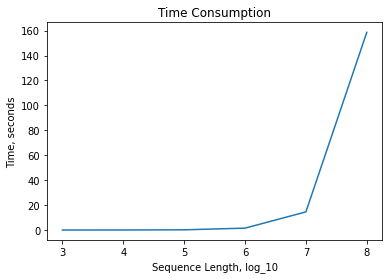

In [137]:
x = np.arange(3, 9, 1)
plt.plot(x, times)
plt.title("Time Consumption")
plt.ylabel("Time, seconds")
plt.xlabel("Sequence Length, log_10")
plt.savefig('time_consumption.jpg')

# Graph of Space Consumption

In [138]:
errors = [0.1, 0.01, 0.001, 0.0001]
memes = []
for e in errors:
  # values for params are taken from
  # http://dimacs.rutgers.edu/~graham/pubs/papers/nquantiles.pdf
  h = math.ceil(np.log(1 / e))
  b = h + 1
  k = math.ceil(1 / e * np.sqrt(h))
  r = 2
  stream = Stream(1000)
  _, meme = mrl99(stream, 0.5, b, k, r, h, True)
  memes.append(meme)
memes.reverse()

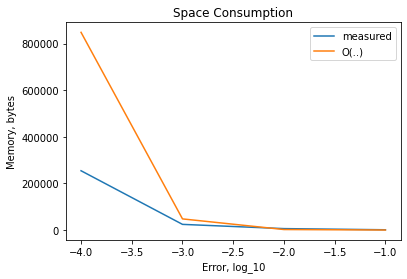

In [139]:
x = np.arange(-4, 0, 1)
plt.plot(x, memes, label = 'measured')

big_oh = []
for e in errors:
  big_oh.append((1 / e) * (np.log(1 / e) ** 2))
big_oh.reverse()
plt.plot(x, big_oh, label = 'O(..)')

plt.title("Space Consumption")
plt.ylabel("Memory, bytes")
plt.xlabel("Error, log_10")
plt.legend()
plt.savefig('space_consumption.jpg')